In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')

In [49]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients
ST_scale=bet/alph

# Establish basic constants 
yr2sec = 365.25*24*60*60
Cp=4000
rho=1024
S0=35

# Range of years of which 'early' and 'late' are defined
dyrs = 9 # if this changes we will need to rerun the gadi masks
init_early = 1970
init_late = 2006
range_yrs = init_late-init_early
Early_period = (np.array([init_early,init_early+dyrs]) - 1970)*12
Late_period = (np.array([init_late,init_late+dyrs]) - 1970)*12

In [50]:
range_yrs

36

In [5]:
%%time
EN4_BSP_data = xr.open_mfdataset('BSP_processed/BSP_EN4_TS_*.nc')

## Early Period
Part_early = EN4_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  EN4_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = EN4_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
V_early = EN4_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = EN4_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')


## Late Period
Part_late = EN4_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  EN4_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = EN4_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
V_late = EN4_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = EN4_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = EN4_BSP_data.Basin.values

CPU times: user 3.53 s, sys: 332 ms, total: 3.86 s
Wall time: 4.27 s


In [6]:

# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [7]:
Opt_result = xr.open_mfdataset('Optimal_result_EN4.nc')

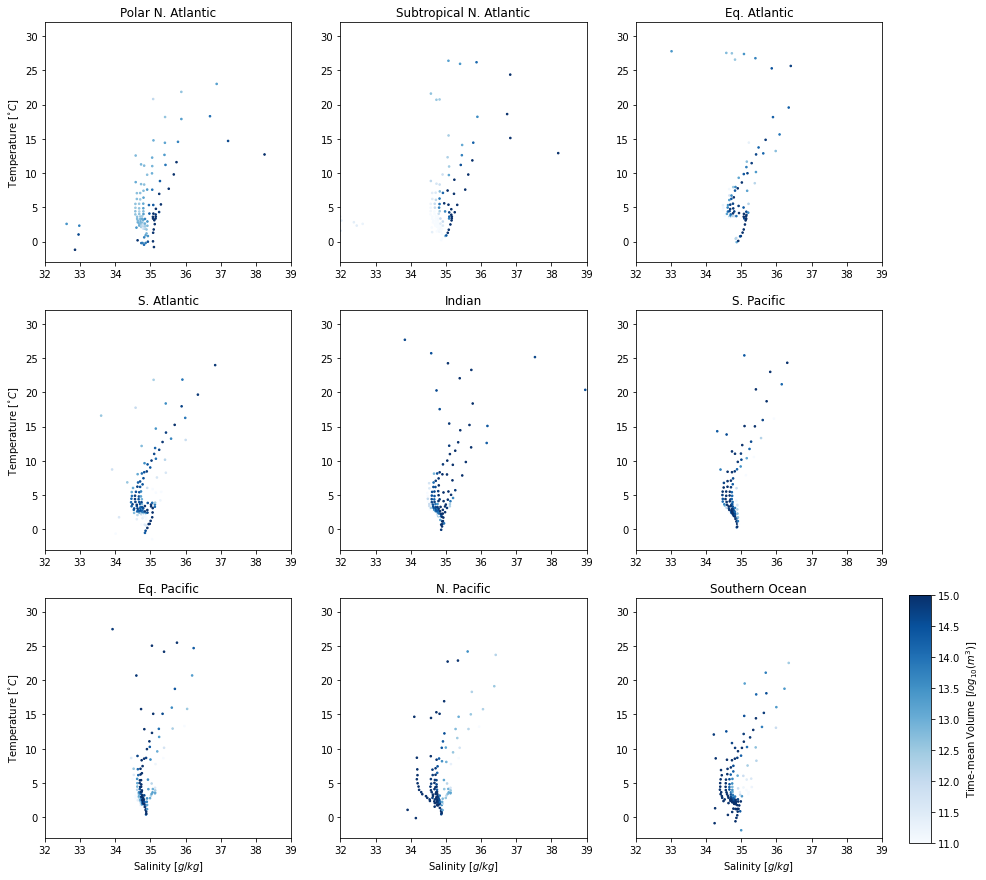

In [8]:
fig, axs = plt.subplots(3,3, figsize=(15,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = 11,15
cmap = 'Blues'

for bx in range(Basins.size):
    axs[bx].scatter(SA_early[bx,:],CT_early[bx,:], 10, np.log10(V_early[bx,:]),cmap=cmap, vmin=minv, vmax=maxv, marker = '.')
    axs[bx].set_xlim(32,39)
    axs[bx].set_ylim(-3,32)
    axs[bx].set_title(Basins[bx])
    if bx==0 or bx==3 or bx==6:
        axs[bx].set_ylabel('Temperature [$^{\circ}C$]')
    if bx==6 or bx==7 or bx==8:
        axs[bx].set_xlabel('Salinity [$g/kg$]')
        
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Time-mean Volume [$log_{10}(m^3)$]') 
# plt.savefig('../../Figures/BSP_clustering_mean_volumes_Vbased.png', bbox_inches='tight', dpi=300)
plt.show()

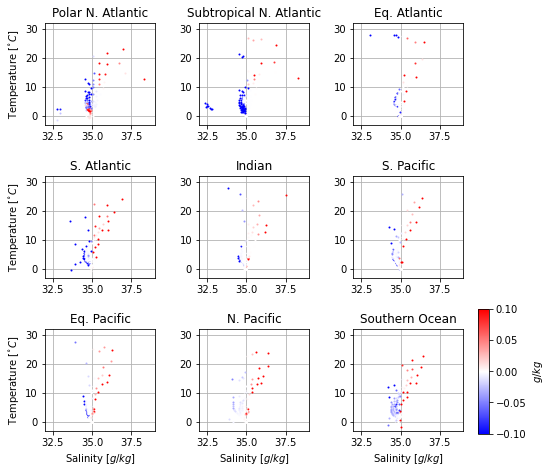

CPU times: user 18.5 s, sys: 849 ms, total: 19.3 s
Wall time: 19.2 s


In [9]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dS_adjustment[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$g/kg$')
plt.show()

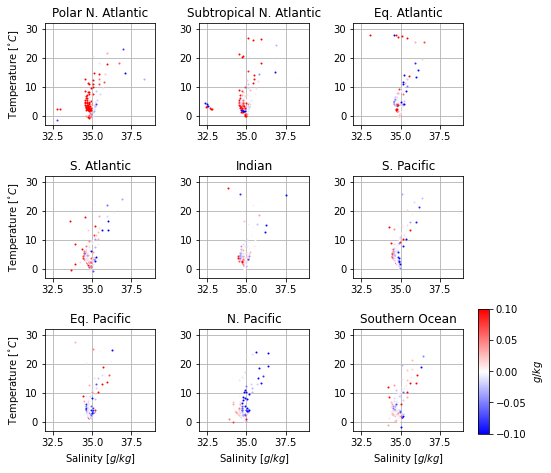

CPU times: user 17.2 s, sys: 798 ms, total: 18 s
Wall time: 18.1 s


In [10]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dS_mixing[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$g/kg$')
plt.show()

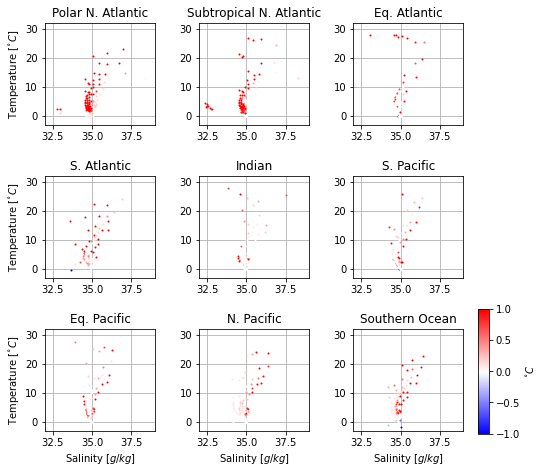

CPU times: user 14.8 s, sys: 563 ms, total: 15.4 s
Wall time: 15.3 s


In [11]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -1,1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dT_adjustment[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$')
plt.show()

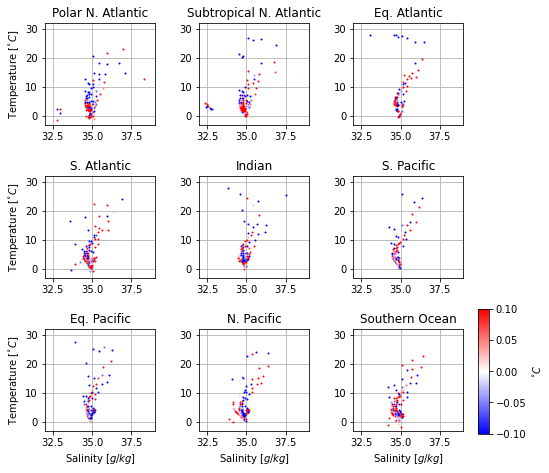

CPU times: user 15 s, sys: 557 ms, total: 15.5 s
Wall time: 15.4 s


In [12]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dT_mixing[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$')
plt.show()

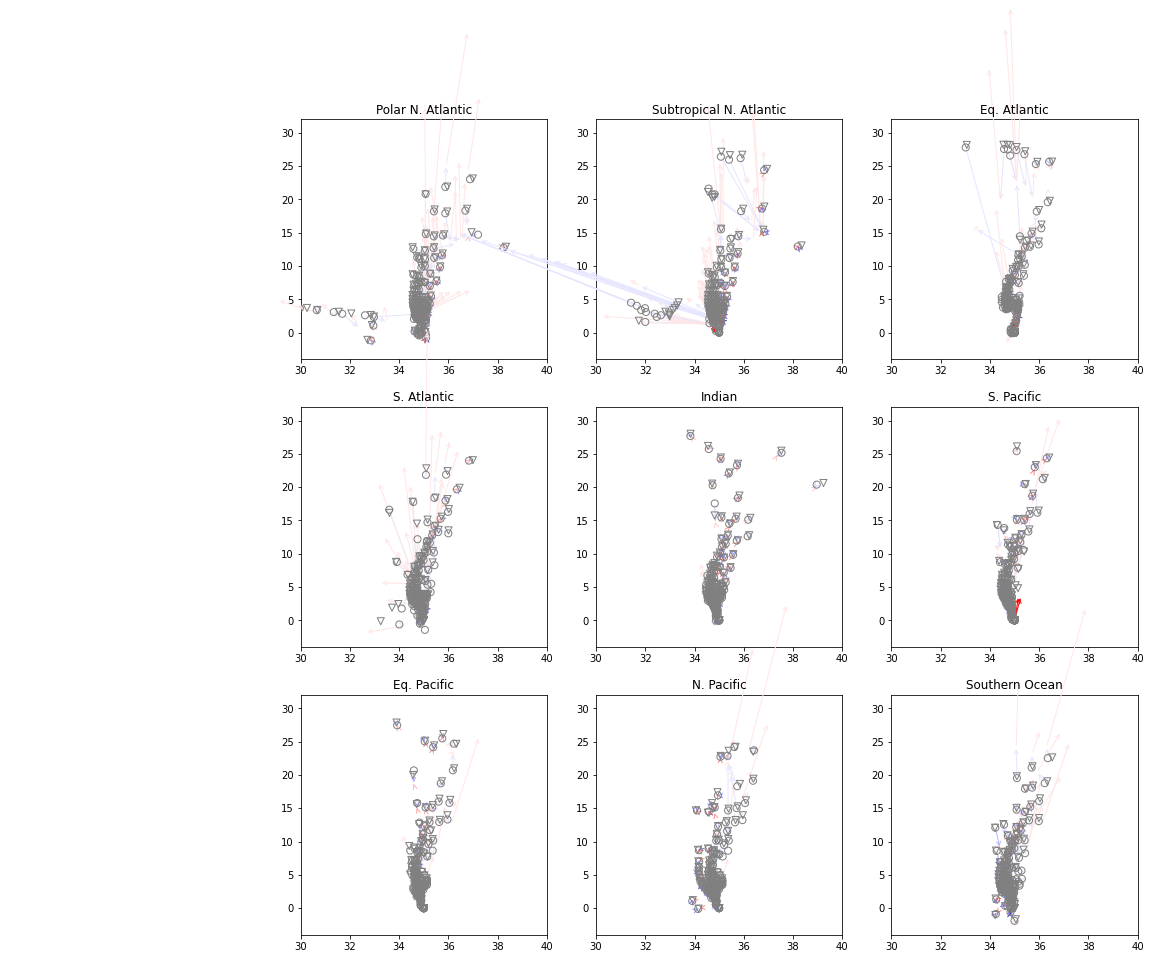

In [13]:
fig, axs = plt.subplots(3,3, figsize=(15,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        col = 1-np.maximum(0.1,(np.log10(Vol_1[k]+1)-14)/(np.log10(np.max(Vol_1))-14))
        axs[i].scatter(S_1[k]+S0,T_1[k],\
                s=50,\
                marker = 'o', facecolor='none', edgecolor='grey', label = 't2', zorder=100)
        axs[i].scatter(S_2[k]+S0,T_2[k],\
                s=50,\
                marker = 'v', facecolor='none', edgecolor='grey', label = 't1', zorder=100)
        if ~np.isnan(Opt_result.dT_mixing[k]) | ~np.isnan(Opt_result.dS_mixing[k]):
                axs[i].annotate('', xy=(S_1[k]+S0, T_1[k]), xytext=(S_1[k]+Opt_result.dS_mixing[k]+S0, T_1[k]+Opt_result.dT_mixing[k]),
    arrowprops=dict(arrowstyle="<-", color=[col,col,1]))
                axs[i].annotate('', xy=(S_1[k]+Opt_result.dS_mixing[k]+S0, T_1[k]+Opt_result.dT_mixing[k]), \
                    xytext=(S_1[k]+Opt_result.dS_mixing[k]+S0+Opt_result.dS_adjustment[k], T_1[k]+Opt_result.dT_mixing[k]+Opt_result.dT_adjustment[k]),
    arrowprops=dict(arrowstyle="<-", color=[1,col,col]))
        else:
                axs[i].annotate('', xy=(S_1[k]+S0, T_1[k]), \
                    xytext=(S_1[k]+S0+Opt_result.dS_adjustment[k], T_1[k]+Opt_result.dT_adjustment[k]),
    arrowprops=dict(arrowstyle="<-", color='red'))
        axs[i].set_xlim(30,40)
        axs[i].set_ylim(-4,32)
        axs[i].set_title(Basins[i])
        k=k+1
plt.show()


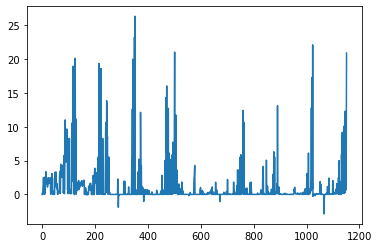

In [14]:
plt.plot(Opt_result.dT_adjustment)

______


In [15]:
## Run below code when MTM is modified, otherwise comment it
## Takes approx 8 mins to run

In [16]:
run MTM_remapping.ipynb

  0%|          | 0/128 [00:00<?, ?it/s]

In [3]:
## LOAD T and S data from a gridded observations (e.g., we use EN4 here)
## For the purposes of the tutorial we only select the first 3 months of the data
data = xr.open_mfdataset('~/UNSW_work/EN4_Data/EN_data/EN4_CT_SA_*')

SST = data.Cons_Temp.isel(time=slice(Early_period[0],Early_period[1])).mean('time', keepdims=True).isel(depth=0)
land_mask = (SST/SST).load()
V = data.dVol.isel(time=slice(Early_period[0],Early_period[1])).mean('time').load()
darea = (data.dArea.isel(time=slice(Early_period[0],Early_period[1])).mean('time')*land_mask).load()


NameError: name 'Early_period' is not defined

In [7]:
print(data.Cons_Temp)

<xarray.DataArray 'Cons_Temp' (time: 540, depth: 42, lat: 173, lon: 360)>
dask.array<concatenate, shape=(540, 42, 173, 360), dtype=float32, chunksize=(1, 42, 173, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * time     (time) datetime64[ns] 1970-01-16T12:00:00 ... 2014-12-16T12:00:00


In [18]:
dT_mix = xr.open_mfdataset('dT_mix_Eulerian.nc').__xarray_dataarray_variable__.values
dS_mix = xr.open_mfdataset('dS_mix_Eulerian.nc').__xarray_dataarray_variable__.values
dT_adj = xr.open_mfdataset('dT_adj_Eulerian.nc').__xarray_dataarray_variable__.values
dS_adj = xr.open_mfdataset('dS_adj_Eulerian.nc').__xarray_dataarray_variable__.values

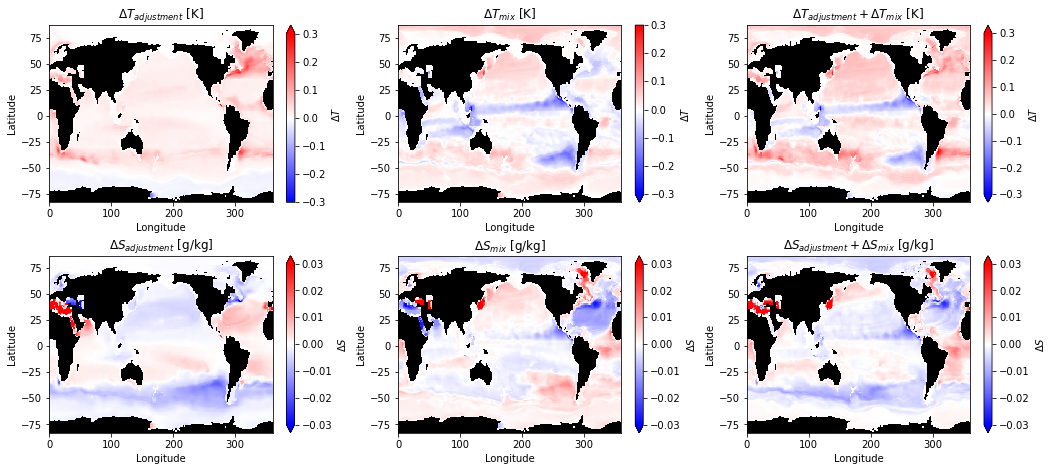

In [19]:
from matplotlib import patches
fig, axs = plt.subplots(2,3, figsize=(17.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.25)
axs = axs.ravel() 

minv, maxv = -0.3,0.3

((dT_mix*V).sum('depth')/V.sum('depth')*SST/SST).plot(ax = axs[1], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta T$'})
axs[1].set_title('$\Delta T_{mix}$ [K]')
((dT_adj*V).sum('depth')/V.sum('depth')*SST/SST).plot(ax = axs[0], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta T$'})
axs[0].set_title('$\Delta T_{adjustment}$ [K]')
(((dT_adj+dT_mix)*V).sum('depth')/V.sum('depth')*SST/SST).plot(ax = axs[2], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta T$'})
axs[2].set_title('$\Delta T_{adjustment} + \Delta T_{mix}$ [K]')

minv, maxv = -0.03,0.03

((dS_mix*V).sum('depth')/V.sum('depth')*SST/SST).plot(ax = axs[4], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta S$'})
axs[4].set_title('$\Delta S_{mix}$ [g/kg]')

((dS_adj*V).sum('depth')/V.sum('depth')*SST/SST).plot(ax = axs[3], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta S$'})
axs[3].set_title('$\Delta S_{adjustment}$ [g/kg]')

(((dS_adj+dS_mix)*V).sum('depth')/V.sum('depth')*SST/SST).plot(ax = axs[5], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta S$'})
axs[5].set_title('$\Delta S_{adjustment} + \Delta S_{mix}$ [g/kg]')

for i in range(6):
    axs[i].add_patch(patches.Rectangle((0,-83), 360, 173, facecolor='black',zorder=-100))
    axs[i].set_ylim(-83,87)
    axs[i].set_xlim(0,360)
    axs[i].set_ylabel('Latitude')
    axs[i].set_xlabel('Longitude')

plt.savefig('Figures/latlon_remapping_noweight.png', dpi=300, bbox_inches='tight')
plt.show()

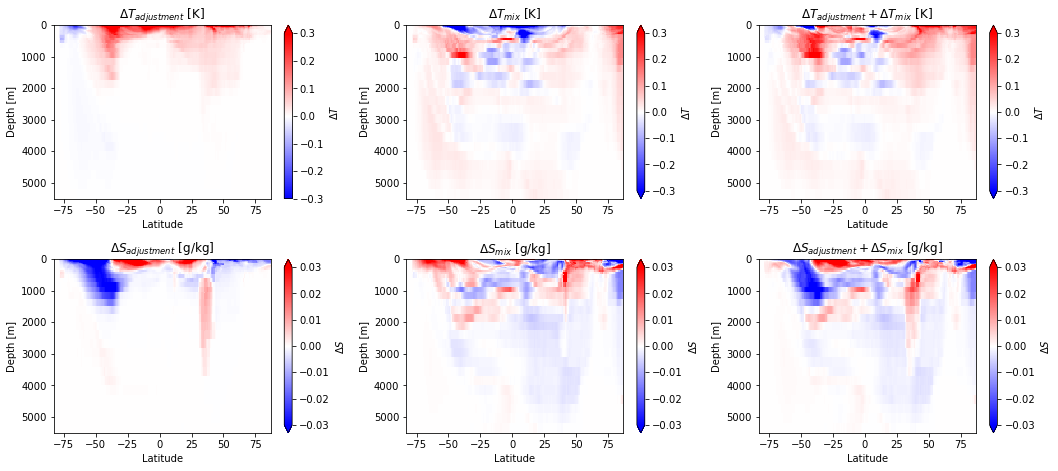

In [21]:
fig, axs = plt.subplots(2,3, figsize=(17.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.35, wspace=0.3)
axs = axs.ravel() 

minv, maxv = -0.3,0.3

((dT_mix*V).sum('lon')/V.sum('lon')).plot(ax = axs[1], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta T$'})
((dT_adj*V).sum('lon')/V.sum('lon')).plot(ax = axs[0], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta T$'})
(((dT_adj+dT_mix)*V).sum('lon')/V.sum('lon')).plot(ax = axs[2], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta T$'})
axs[1].set_title('$\Delta T_{mix}$ [K]')
axs[0].set_title('$\Delta T_{adjustment}$ [K]')
axs[2].set_title('$\Delta T_{adjustment} + \Delta T_{mix}$ [K]')

minv, maxv = -0.03,0.03

((dS_mix*V).sum('lon')/V.sum('lon')*V.sum('lon')/V.sum('lon')).plot(ax = axs[4], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta S$'})
((dS_adj*V).sum('lon')/V.sum('lon')*V.sum('lon')/V.sum('lon')).plot(ax = axs[3], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta S$'})
(((dS_adj+dS_mix)*V).sum('lon')/V.sum('lon')*V.sum('lon')/V.sum('lon')).plot(ax = axs[5], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta S$'})
axs[4].set_title('$\Delta S_{mix}$ [g/kg]')
axs[3].set_title('$\Delta S_{adjustment}$ [g/kg]')
axs[5].set_title('$\Delta S_{adjustment} + \Delta S_{mix}$ [g/kg]')

for i in range(6):
    axs[i].set_xlim(-83,87)
    # axs[i].set_ylim(0,6000)
    axs[i].invert_yaxis()
    axs[i].set_ylabel('Depth [m]')
    axs[i].set_xlabel('Latitude')
    # axs[i].add_patch(patches.Rectangle((-83,0), 173, 6000, facecolor='black',zorder=-100))

plt.savefig('Figures/latdepth_remapping_noweight.png', dpi=300, bbox_inches='tight')
plt.show()

In [81]:
CT_eul_early = data.Cons_Temp.isel(time=slice(Early_period[0],Early_period[1])).mean('time')
CT_eul_late = data.Cons_Temp.isel(time=slice(Late_period[0],Late_period[1])).mean('time')

SA_eul_early = data.Abs_Sal.isel(time=slice(Early_period[0],Early_period[1])).mean('time')
SA_eul_late = data.Abs_Sal.isel(time=slice(Late_period[0],Late_period[1])).mean('time')

# Compute Eulerian change in temperature (just a simple difference)
dT_eul=CT_eul_late-CT_eul_early
# Compute depth integrated heat content (units: W/m^2)
dH_mix = Cp*rho*(dT_mix*V).sum('depth')/(darea*range_yrs*yr2sec)
dH_eul = Cp*rho*(dT_eul*V).sum('depth')/(darea*range_yrs*yr2sec)
dH_adj = Cp*rho*(dT_adj*V).sum('depth')/(darea*range_yrs*yr2sec)

dH_redist = dH_eul-dH_mix-dH_adj

# # Compare Mixing, Redistribution and Adjustment fresh water change
# # Compute Eulerian change in temperature (just a simple difference)
dS_eul=SA_eul_late-SA_eul_early
# Compute implied fresh water content change (units: mm/yr)
dW_mix = (-1/S0)*(dS_mix*V).sum('depth')/(darea*range_yrs)*1000
dW_eul = (-1/S0)*(dS_eul*V).sum('depth')/(darea*range_yrs)*1000
dW_adj = (-1/S0)*(dS_adj*V).sum('depth')/(darea*range_yrs)*1000

dW_redist = dW_eul - dW_mix - dW_adj

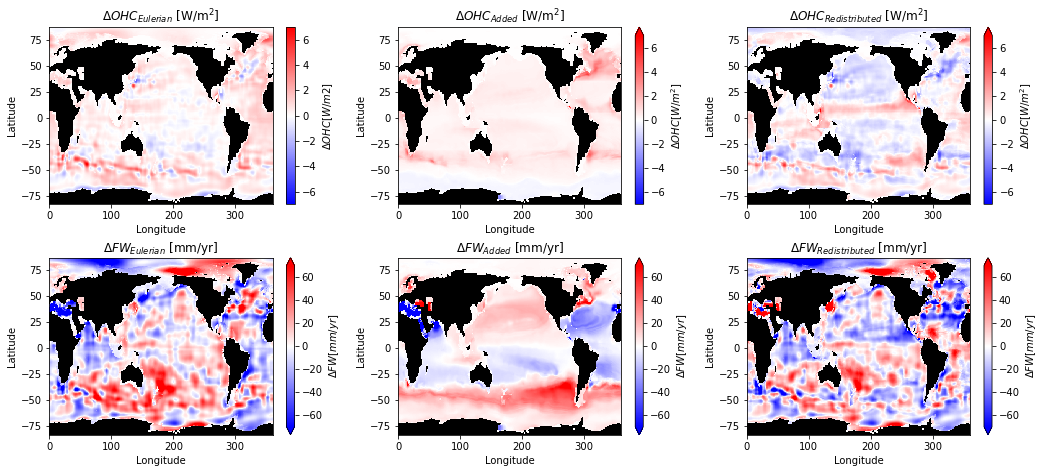

In [83]:
from matplotlib import patches
fig, axs = plt.subplots(2,3, figsize=(17.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.25)
axs = axs.ravel() 

minv, maxv = -7,7

(dH_adj).plot(ax = axs[1], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta OHC [W/m^2]$'})
axs[1].set_title('$\Delta OHC_{Added}$ [W/m$^2$]')
dH_eul.plot(ax = axs[0], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta OHC [W/m2]$'})
axs[0].set_title('$\Delta OHC_{Eulerian}$ [W/m$^2$]')
dH_redist.plot(ax = axs[2], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta OHC [W/m^2]$'})
axs[2].set_title('$\Delta OHC_{Redistributed}$ [W/m$^2$]')

minv, maxv = -70,70

(dW_adj).plot(ax = axs[4], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta FW [mm/yr]$'})
axs[4].set_title('$\Delta FW_{Added}$ [mm/yr]')
dW_eul.plot(ax = axs[3], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta FW [mm/yr]$'})
axs[3].set_title('$\Delta FW_{Eulerian}$ [mm/yr]')
dW_redist.plot(ax = axs[5], vmin=minv, vmax=maxv, cmap=plt.cm.bwr, cbar_kwargs={'label':'$\Delta FW [mm/yr]$'})
axs[5].set_title('$\Delta FW_{Redistributed}$ [mm/yr]')

for i in range(6):
    axs[i].add_patch(patches.Rectangle((0,-83), 360, 173, facecolor='black',zorder=-100))
    axs[i].set_ylim(-83,87)
    axs[i].set_xlim(0,360)
    axs[i].set_ylabel('Latitude')
    axs[i].set_xlabel('Longitude')

plt.savefig('Figures/latlon_remapping_OHC_FW.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
print((dT_mix*V).sum())
print((dT_adj*V).sum())
print((dT_eul*V).sum().values)

<xarray.DataArray 'dVol' ()>
array(3.02953702e+12)
<xarray.DataArray 'dVol' ()>
array(4.66967991e+16)
4.41397745377501e+16


In [71]:
print((dS_mix*V).sum())
print((dS_adj*V).sum())
print((dS_eul*V).sum().values)

<xarray.DataArray 'dVol' ()>
array(1.01251241e+12)
<xarray.DataArray 'dVol' ()>
array(-1.38737728e+15)
-1289192702623960.5
